In [30]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import *
from keras.utils import np_utils
%matplotlib inline

In [31]:
cd G:\My Drive\Colab Notebooks\DAV Assessment\Cefas_smartbuoy

G:\My Drive\Colab Notebooks\DAV Assessment\Cefas_smartbuoy


In [32]:
df = pd.read_csv('clean_ext_data.csv', parse_dates = ['dateTime'])
df = df.set_index('dateTime')
df = df.drop('kd', axis = 1)
df = df.dropna()

phase_0 = df.loc[df['phase'] == 0, :].copy()
X = phase_0.drop(['fluors', 'phase'], axis = 1).copy()
y = phase_0['fluors'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# standardize the data
scaler = StandardScaler()
#train the scaler on the training data
X_train = scaler.fit_transform(X_train)
#apply the scaler to the test data sets
X_test = scaler.transform(X_test)
X = scaler.transform(X)

phase_1 = df.loc[df['phase'] > 0, :].copy()
X_1 = phase_1.drop(['fluors', 'phase'], axis = 1).copy()
y_1 = phase_1.loc[:, 'fluors'].copy()
scaler = StandardScaler()
X_1 = scaler.fit_transform(X_1)

Creating a simple baseline neural network

In [61]:
simple_model = Sequential()
simple_model.add(Dense(units = 10, activation = "relu", input_shape = (4, )))
simple_model.add(Dense(1, activation = "relu"))
simple_model.summary()
simple_model.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ['mean_squared_error'])
no_epochs = 8
history = simple_model.fit(X_train, y_train, batch_size = 100, epochs = no_epochs, verbose = 0, validation_data = (X_test, y_test))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 10)                50        
                                                                 
 dense_9 (Dense)             (None, 1)                 11        
                                                                 
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


In [70]:
ls *.h5

 Volume in drive G is Google Drive
 Volume Serial Number is 1983-1116

 Directory of G:\My Drive\Colab Notebooks\DAV Assessment\Cefas_smartbuoy

04/12/2022  17:55         6,710,880 b2e20_1.h5
04/12/2022  22:10        18,127,424 b3e8_3.h5
04/12/2022  19:46         9,120,624 b6e15_2.h5
28/11/2022  16:52         9,737,336 final_model.h5
08/12/2022  16:17         3,457,984 good_model_b10_e13.h5
08/12/2022  15:02         3,457,984 good_model_b3_e11.h5
02/12/2022  15:55        18,798,920 model.h5
08/12/2022  17:31            34,728 model_for_visualisation.h5
               8 File(s)     69,445,880 bytes
               0 Dir(s)  14,693,945,344 bytes free


In [72]:
good_model = keras.models.load_model('model_for_visualisation.h5', compile = False)
dummy_regr = DummyRegressor(strategy = "mean")
dummy_regr.fit(X_train, y_train)
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
poly_reg = PolynomialFeatures(degree = 3, include_bias = False)
X_poly = poly_reg.fit_transform(X_train)
poly_reg.fit(X_poly, y_train)
lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly, y_train)

LinearRegression()

In [73]:
#predictions on training data
pred_train = model.predict(X_train)
dummy_pred_train = dummy_regr.predict(X_train)
lin_pred_train = lin_reg.predict(X_train)
poly_pred_train = lin_reg2.predict(poly_reg.fit_transform(X_train))
simple_pred_train = simple_model.predict(X_train)

#predictions on test data
pred_test = model.predict(X_test)
dummy_pred_test = dummy_regr.predict(X_test)
lin_pred_test = lin_reg.predict(X_test)
poly_pred_test = lin_reg2.predict(poly_reg.fit_transform(X_test))
simple_pred_test = simple_model.predict(X_test)

#predictions on pre-construction data
fluors_pred = model.predict(X)
dummy_fluors_pred = dummy_regr.predict(X)
lin_fluors_pred = lin_reg.predict(X)
poly_fluors_pred = lin_reg2.predict(poly_reg.fit_transform(X))
simple_fluors_pred = simple_model.predict(X)

#predictions on post-construction data
fluors_pred_1 = model.predict(X_1)
dummy_fluors_pred_1 = dummy_regr.predict(X_1)
lin_fluors_pred_1 = lin_reg.predict(X_1)
poly_fluors_pred_1 = lin_reg2.predict(poly_reg.fit_transform(X_1))
simple_fluors_pred_1 = simple_model.predict(X_1)

#adding predictions to dataframe
phase_0.loc[:, 'fluors_pred'] = fluors_pred
phase_0.loc[:, 'dummy_fluors_pred'] = dummy_fluors_pred
phase_0.loc[:, 'lin_fluors_pred'] = lin_fluors_pred
phase_0.loc[:, 'poly_fluors_pred'] = poly_fluors_pred
phase_0.loc[:, 'simple_fluors_pred'] = simple_fluors_pred
phase_1.loc[:, 'fluors_pred'] = fluors_pred_1
phase_1.loc[:, 'dummy_fluors_pred'] = dummy_fluors_pred_1
phase_1.loc[:, 'lin_fluors_pred'] = lin_fluors_pred_1
phase_1.loc[:, 'poly_fluors_pred'] = poly_fluors_pred_1
phase_1.loc[:, 'simple_fluors_pred'] = simple_fluors_pred_1

1904/1904 [==============================] - 2s 1ms/step


In [74]:
def plot(x, y, y_pred, save_as = '', x_label = '', y_label = ''):
    fig, ax = plt.subplots(figsize = (15, 7), dpi = 600)
    ax.scatter(x, y, s = 0.5, color = 'blue')
    ax.scatter(x, y_pred, s = 0.5, color = 'red')
    locator = mdate.YearLocator()
    ax.xaxis.set_major_locator(locator)
    fig.autofmt_xdate()
    ax.set_xlabel(x_label, fontsize = 15)
    ax.set_ylabel(y_label, fontsize = 15)
    ax.grid(visible = True, which = 'major', axis = 'both')
    if len(save_as) > 0:
        print('Saving...')
        fig.savefig(save_as + '.png', dpi = 600, format = 'png')
    fig.show()

Saving...


C:\Users\Reuben\AppData\Local\Temp\ipykernel_11476\433563554.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


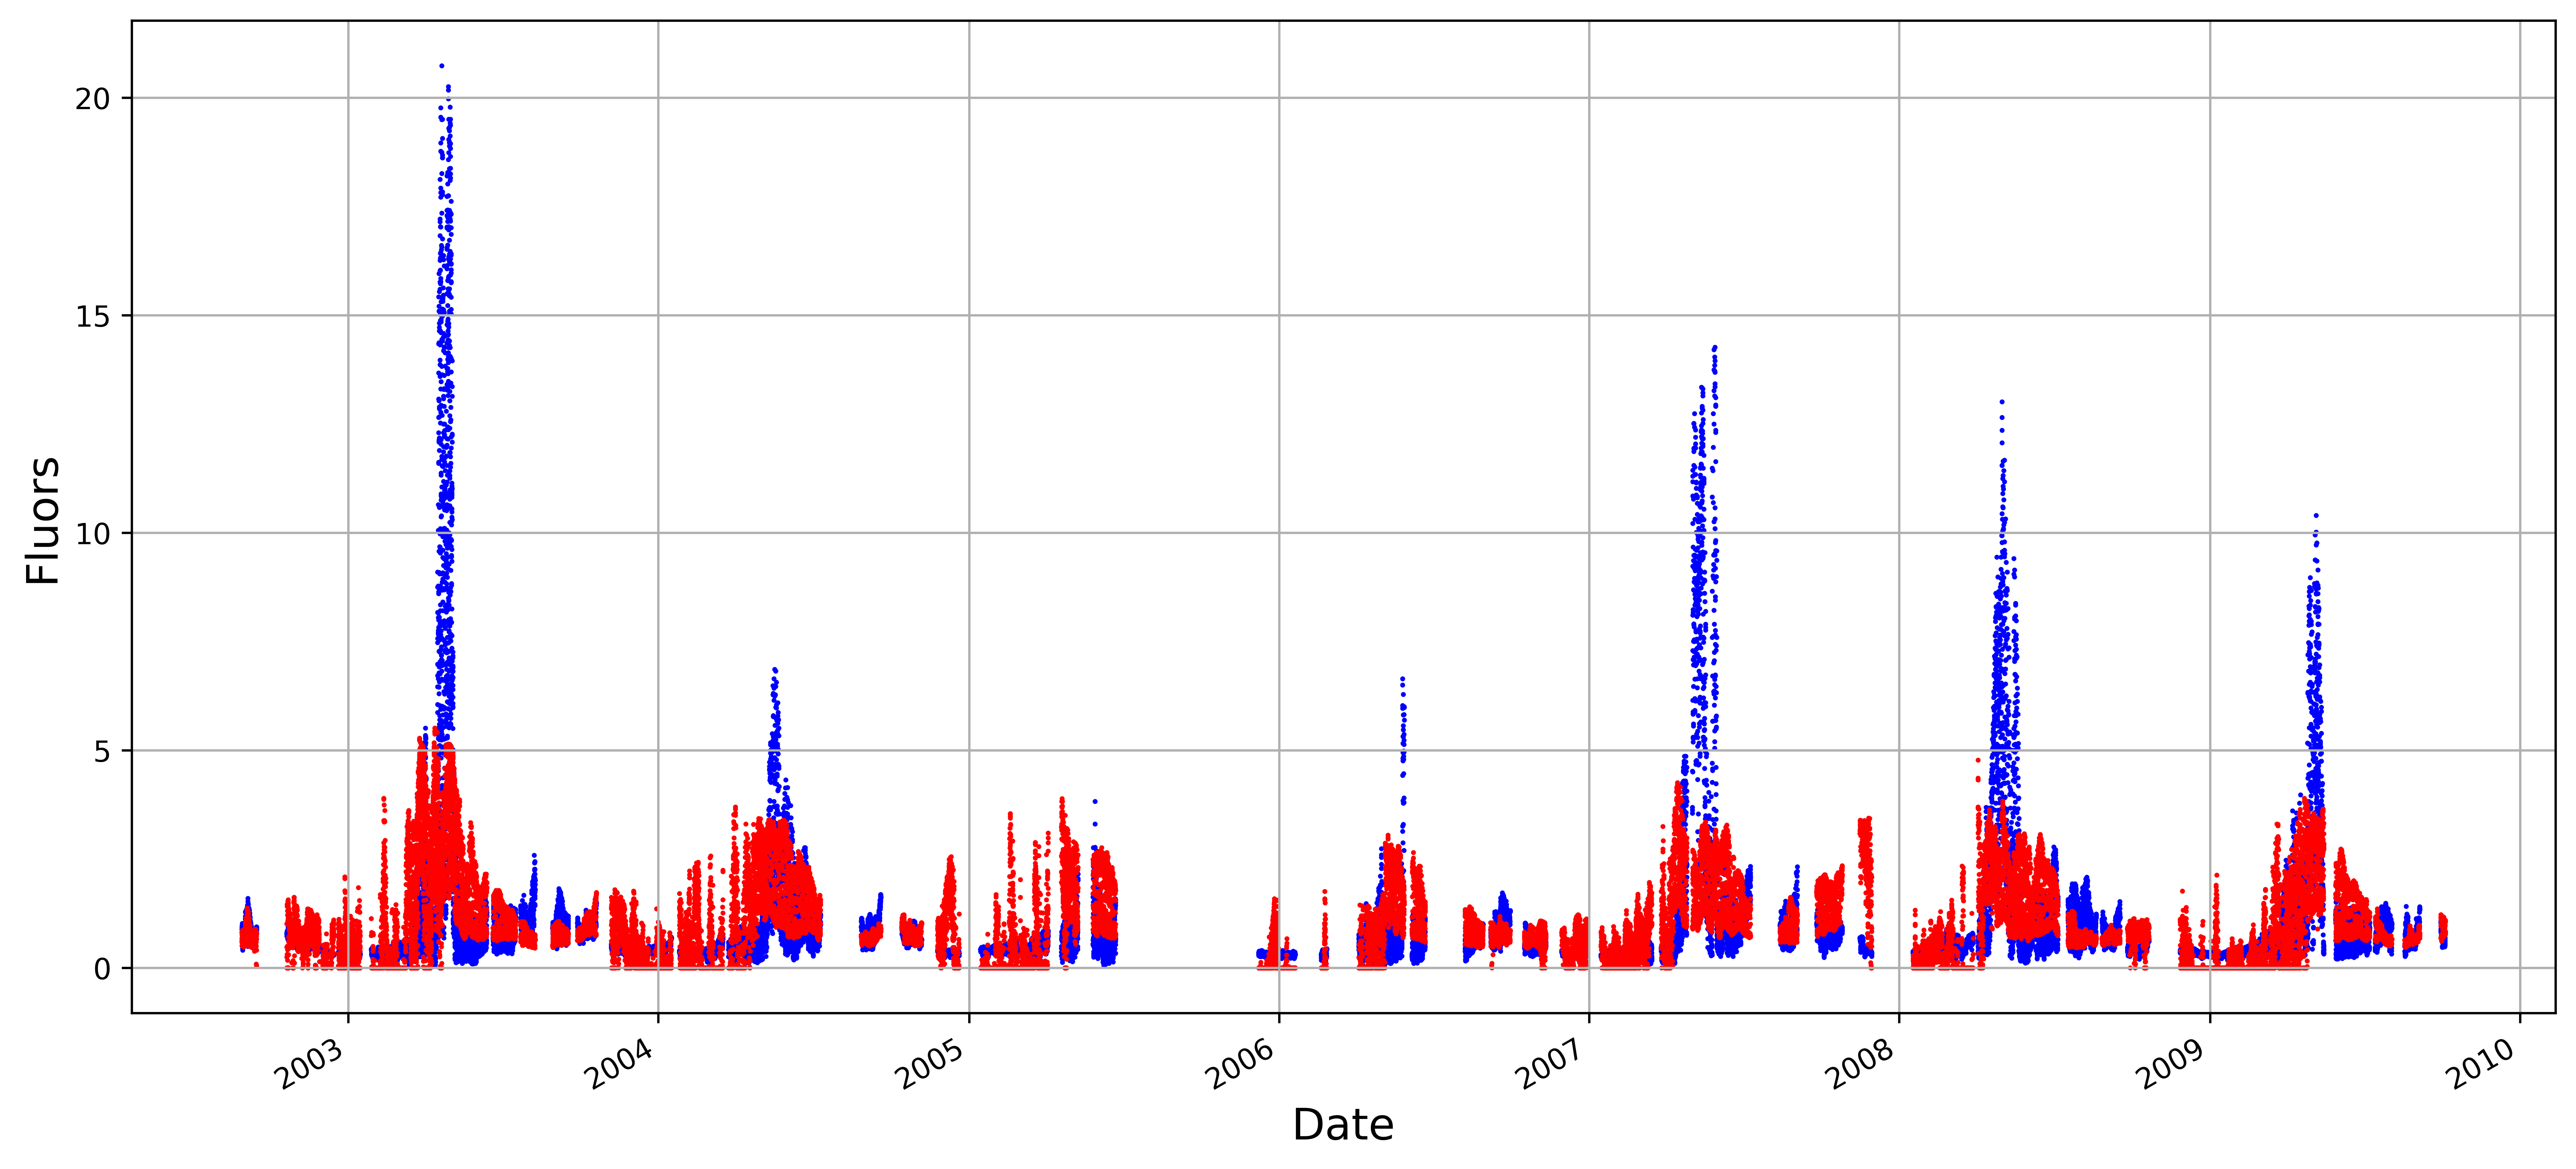

In [75]:
plot(phase_0.index, phase_0['fluors'], phase_0['simple_fluors_pred'], save_as = 'testing', x_label = 'Date', y_label = 'Fluors')

In [76]:
#make root mean squared error function
def rmse(a, b):
    return np.sqrt(mean_squared_error(a, b))
#function to display erorrs for each model in given data period
def comparison(data_period = 'test', metric = 'rms'):
    #the different metrics
    metric_dict = {'rms' : rmse, 'r2' : r2_score, 'mae' : median_absolute_error, 'mape' : mean_absolute_percentage_error}
    #the 5 models
    list = ['ANN', 'Dummy', 'Linear', 'Polynomial', 'Simple']
    dictionary = {'ANNtest' : pred_test,
    'ANNtrain' : pred_train,
    'ANNpre-construction' : fluors_pred,
    'ANNpost-construction' : fluors_pred_1,
    'Dummytest' : dummy_pred_test,
    'Dummytrain' : dummy_pred_train,
    'Dummypre-construction' : dummy_fluors_pred,
    'Dummypost-construction' : dummy_fluors_pred_1,
    'Lineartest' : lin_pred_test,
    'Lineartrain' : lin_pred_train,
    'Linearpre-construction' : lin_fluors_pred,
    'Linearpost-construction' : lin_fluors_pred_1,
    'Polynomialtest' : poly_pred_test,
    'Polynomialtrain' : poly_pred_train,
    'Polynomialpre-construction' : poly_fluors_pred,
    'Polynomialpost-construction' : poly_fluors_pred_1,
    'Simpletest' : simple_pred_test,
    'Simpletrain' : simple_pred_train,
    'Simplepre-construction' : simple_fluors_pred,
    'Simplepost-construction' : simple_fluors_pred_1
    }
    data_period_dict = {'test' : y_test, 'train' : y_train, 'pre-construction' : y, 'post-construction' : y_1}
    for baseline in list:
        print(f'{baseline} {data_period} {metric} error: {metric_dict[metric](data_period_dict[data_period], dictionary[baseline + data_period]):.2f}')
    print('')

In [77]:
comparison(data_period = 'test' , metric = 'rms')
comparison(data_period = 'test' , metric = 'r2')
comparison(data_period = 'test' , metric = 'mae')
comparison(data_period = 'test' , metric = 'mape')

ANN test rms error: 1.18
Dummy test rms error: 1.86
Linear test rms error: 1.76
Polynomial test rms error: 1.61
Simple test rms error: 1.67

ANN test r2 error: 0.60
Dummy test r2 error: -0.00
Linear test r2 error: 0.11
Polynomial test r2 error: 0.25
Simple test r2 error: 0.20

ANN test mae error: 0.21
Dummy test mae error: 0.62
Linear test mae error: 0.48
Polynomial test mae error: 0.43
Simple test mae error: 0.41

ANN test mape error: 0.72
Dummy test mape error: 1.25
Linear test mape error: 1.17
Polynomial test mape error: 1.09
Simple test mape error: 1.10



C:\Users\Reuben\AppData\Local\Temp\ipykernel_11476\92902749.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


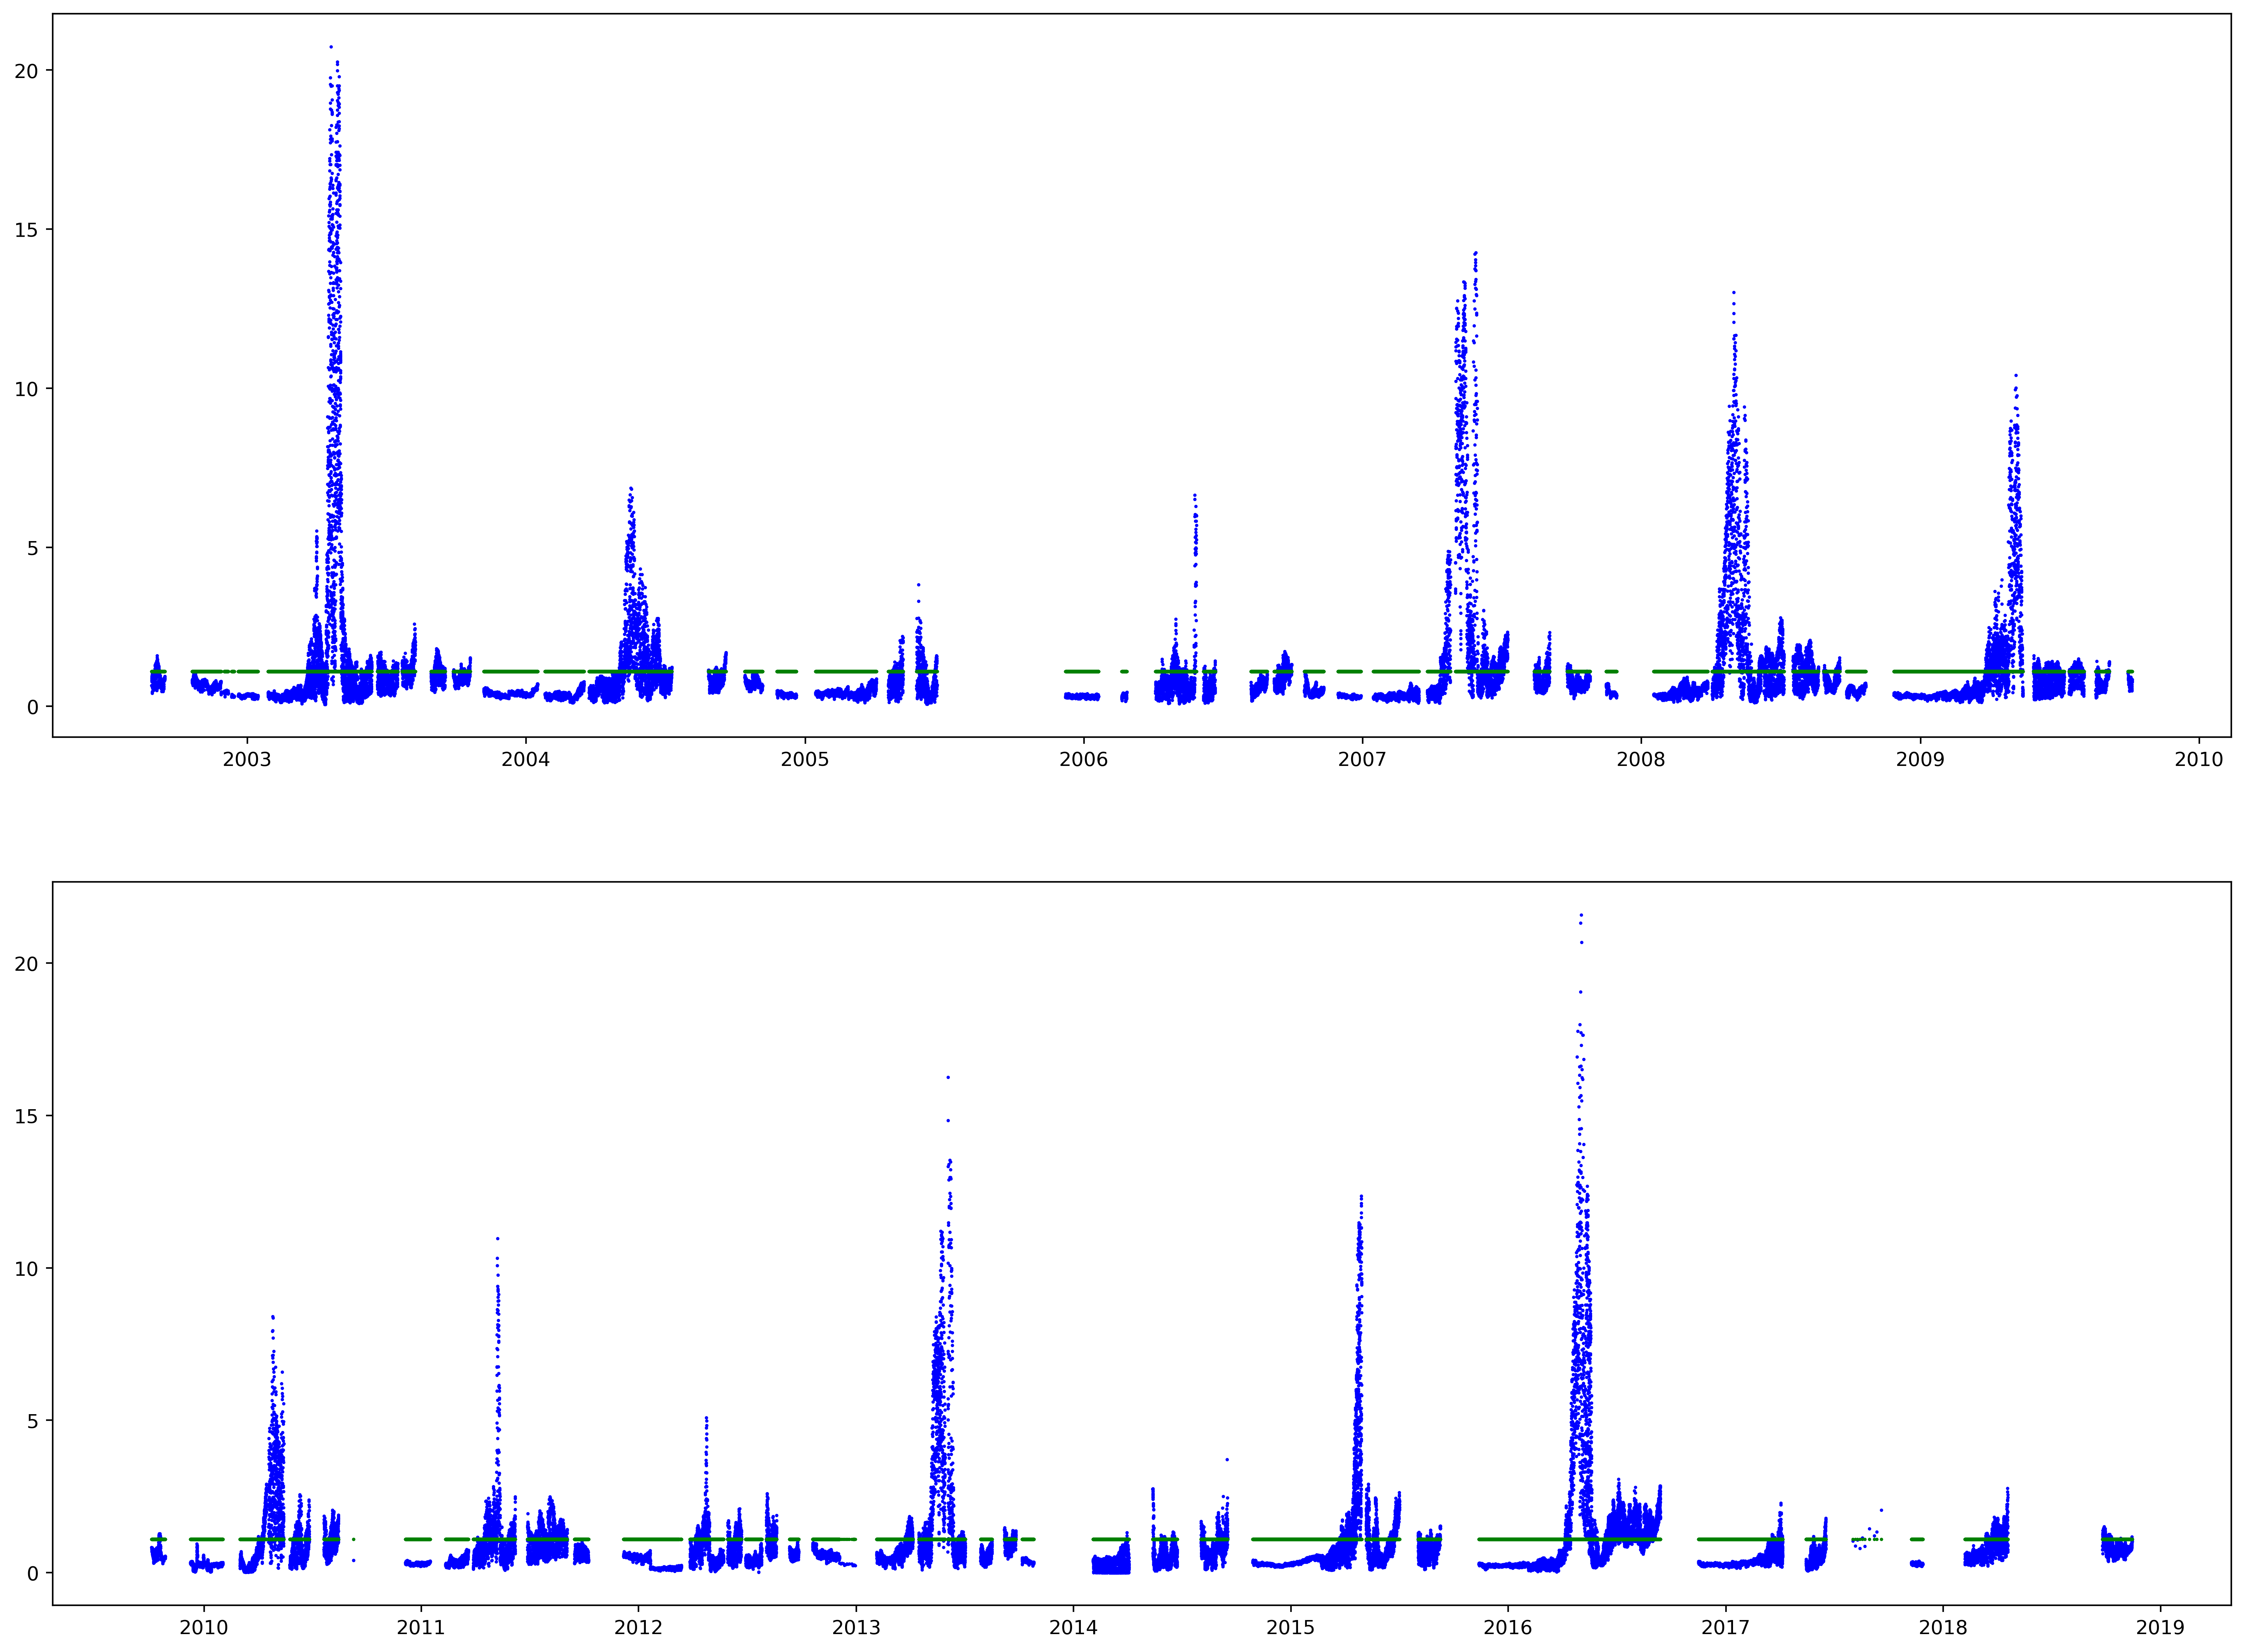

In [78]:
fig, ax = plt.subplots(2,1, figsize = (20, 15), dpi = 400)
ax[0].scatter(phase_0.index, phase_0['fluors'], s = 0.5, color = 'blue')
# ax[0].scatter(phase_0.index, phase_0['fluors_pred'], s = 0.5, color = 'red', alpha = 0.6)
# ax[0].scatter(phase_0.index, phase_0['lin_fluors_pred'], s = 0.5, color = 'orange')
# ax[0].scatter(phase_0.index, phase_0['poly_fluors_pred'], s = 0.5, color = 'purple')
ax[0].scatter(phase_0.index, phase_0['dummy_fluors_pred'], s = 0.5, color = 'green')
ax[1].scatter(phase_1.index, phase_1['fluors'], s = 0.5, color = 'blue')
# ax[1].scatter(phase_1.index, phase_1['fluors_pred'], s = 0.5, color = 'red', alpha = 0.6)
# ax[1].scatter(phase_1.index, phase_1['lin_fluors_pred'], s = 0.5, color = 'orange')
# ax[1].scatter(phase_1.index, phase_1['poly_fluors_pred'], s = 0.5, color = 'purple')
ax[1].scatter(phase_1.index, phase_1['dummy_fluors_pred'], s = 0.5, color = 'green')
#fig.savefig('model_predictions.png', dpi = 400)
fig.show()

In [79]:
def scatterplot(x,y):# Read data

    # linear regression of y on x (scipy)

    import scipy.stats as stats
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    from scipy.stats import gaussian_kde
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

    # plot linear regression

    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    fig, ax = plt.subplots(figsize=(7,6),dpi=100)
    maxNum = max(x)
    minNum = min(x)
    ax.plot(x, x, color='blue', linewidth=1,label = '1:1 line')#reference line
    ax.plot(x, intercept + slope*x, 'r', label='fitted line y = {:.2f}x + {:.2f}'.format(slope,intercept))
    ax.legend()
    # ax.set_xlabel('Buoy Temp')
    # ax.set_ylabel('CMEMS SST')
    plt.xlim(minNum, maxNum)
    plt.ylim(minNum, maxNum)
    #Least squares fit

    xcord = x
    ycord = y

    m = ((xcord*ycord).mean() - xcord.mean()* ycord.mean())/(pow(xcord,2).mean()-pow(xcord.mean(),2))

    c = ycord.mean() - m*xcord.mean()
    # Plot
    y1=m*x+c  
    scatter=ax.scatter(x,y,marker='o',c=z,edgecolors='none',s=15,label='LST',cmap='Spectral_r')
    divider=make_axes_locatable(ax)
    cax = divider.append_axes("right",size="3%",pad=0.1)
    cbar = fig.colorbar(scatter, cax=cax, label='frequency')
    cbar = fig.colorbar(scatter,cax=cax,extend='both',aspect=30,fraction=.03,pad=0.01)

    # plt.savefig('plot82.1.png',dpi=800,bbox_inches='tight',pad_inches=0)
    plt.show()

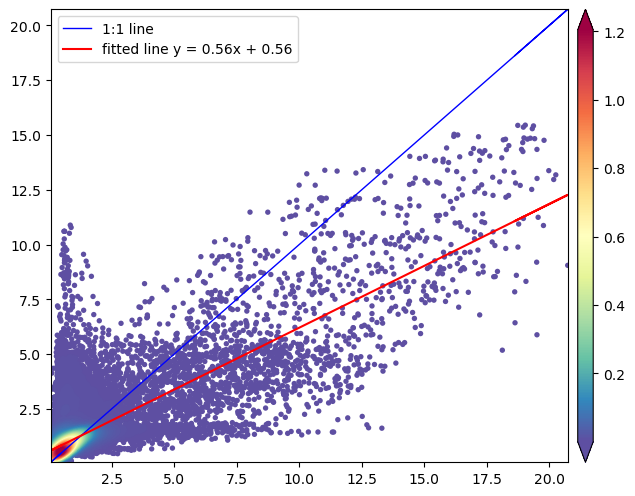

In [80]:
# phase_0['fluors'] vs phase_0['fluors_pred'] (Training set)
scatterplot(phase_0['fluors'], phase_0['fluors_pred'])

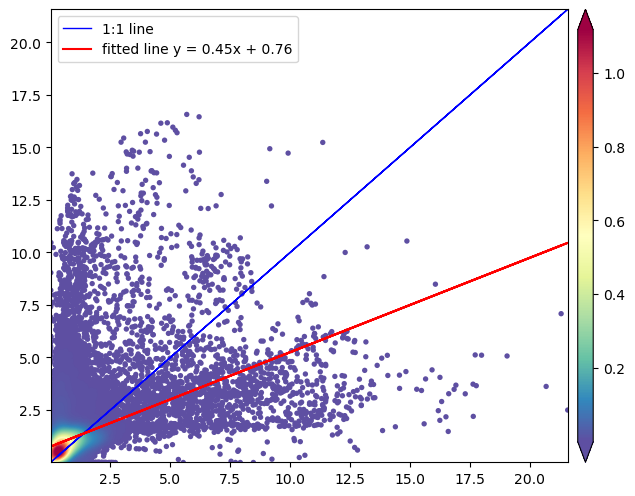

In [81]:
# phase_1['fluors'] vs phase_1['fluors_pred'] (Test set)
scatterplot(phase_1['fluors'], phase_1['fluors_pred'])

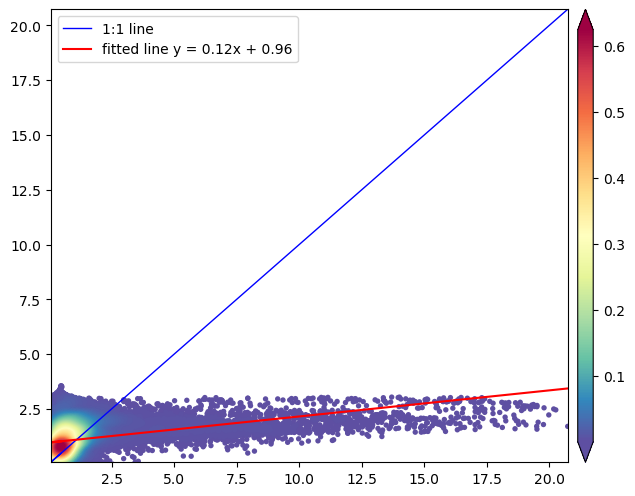

In [82]:
# phase_0['fluors'] vs phase_0['lin_fluors_pred'] (Training set)
scatterplot(phase_0['fluors'], phase_0['lin_fluors_pred'])

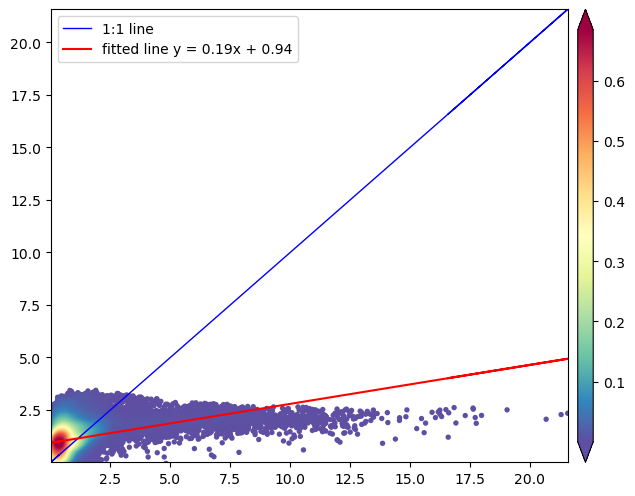

In [83]:
# phase_1['fluors'] vs phase_1['lin_fluors_pred'] (Test set)
scatterplot(phase_1['fluors'], phase_1['lin_fluors_pred'])

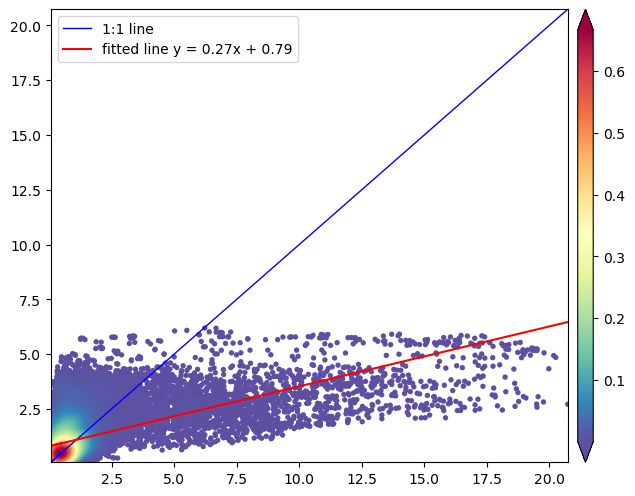

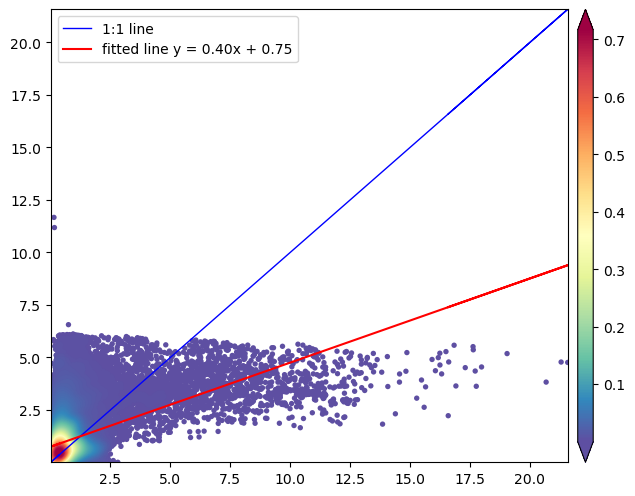

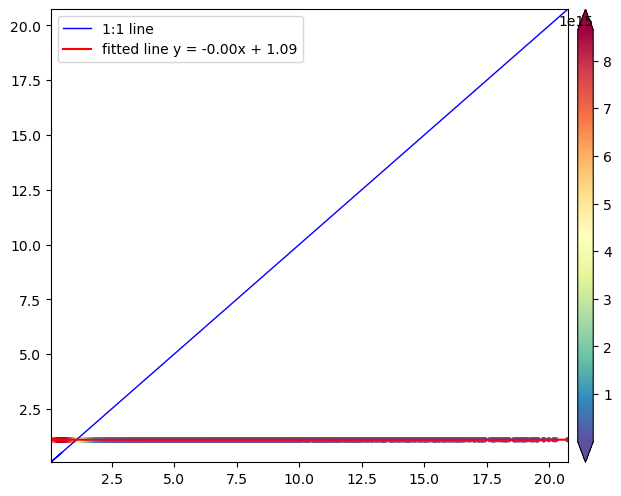

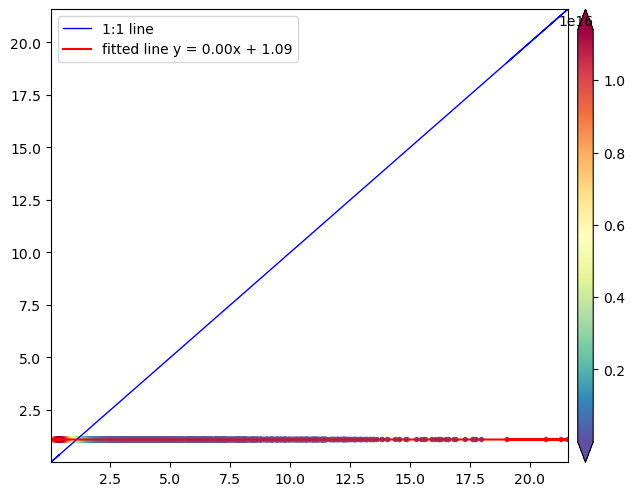

In [84]:
# phase_0['fluors'] vs phase_0['poly_fluors_pred'] (Training set)
scatterplot(phase_0['fluors'], phase_0['poly_fluors_pred'])

# phase_1['fluors'] vs phase_1['poly_fluors_pred'] (Test set)
scatterplot(phase_1['fluors'], phase_1['poly_fluors_pred'])

# phase_0['fluors'] vs phase_0['dummy_fluors_pred'] (Training set)
scatterplot(phase_0['fluors'], phase_0['dummy_fluors_pred'])

# phase_1['fluors'] vs phase_1['dummy_fluors_pred'] (Test set)
scatterplot(phase_1['fluors'], phase_1['dummy_fluors_pred'])
